# Предобработка

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df2 = pd.read_csv('competitors.csv', sep=';')

In [ ]:
df2_skus = set(df2['Sku (Sku)'].values)

In [ ]:
df = pd.read_csv('report.csv', sep=';')

In [ ]:
df['Время (CollectedAt)'] = df['Время (CollectedAt)'].apply(lambda x: x.split()[0])
df = df[df['Sku (Sku)'].apply(lambda x: x in df2_skus)]
norm_size = df.drop_duplicates()

In [ ]:
norm_size['Время (CollectedAt)'].nunique()

29

In [ ]:
norm_size.to_csv('norm_size_time.csv', sep=';', encoding='utf-8-sig', index=False)

In [ ]:
df_prices = pd.read_csv('norm_size_time.csv', sep=';')

In [ ]:
import requests
from PIL import Image
from io import BytesIO

In [ ]:
df2.drop(df2[df2['Фото (CoverImage)'].isna()].index, inplace=True)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
df2.loc[:, 'Фото (CoverImage)'] = df2['Фото (CoverImage)'].progress_apply(lambda x: BytesIO(requests.get(x, headers={"User-Agent": "Mozilla/5.0"}).content).getvalue())

100%|██████████████████████████████████████████████████████████████████████████████| 5562/5562 [12:39<00:00,  7.33it/s]


In [ ]:
df2.to_pickle("dataset_with_images.pkl")

In [ ]:
df2 = pd.read_pickle("dataset_with_images.pkl")

In [ ]:
df2.drop(['Цена соинвест (DiscountPrice)', 'Цена по карте (OzonCardPrice)', 'Ошибка загрузки (CrawlerError)', 'Валюта (Currency)', 'Цена до скидки (BasePrice)', 'Рейтинг товара (AvgRating)', 'Количество отзывов (Reviews)', 'SellerProductId (SellerProductId)', 'Rich-контент (RichContent)', 'Link (Link)', 'Сток FBO (StockFbm)', 'Сток FBS (StockFbs)'], axis=1, inplace=True)

In [ ]:
df_prices.loc[:, 'Время (CollectedAt)'] = pd.to_datetime(df_prices['Время (CollectedAt)'], format='%d.%m.%Y')

In [ ]:
df2.isna().any()

In [ ]:
df2 = df2.fillna('')

In [ ]:
df2['Text'] = df2.apply(lambda x: f"Название товара: {x['Название товара (ProductName)']}. Продавец: {x['Продавец (SellerName)']}. Бренд: {x['Бренд (BrandName)']}. Название категории: {x['Название категории (CategoryName)']}. Описание: {x['Описание (Description)']}", axis=1)

# Выявление конкурентов

Создание текстовых эмбеддингов и эмбеддингов изображений

In [ ]:
def chunk_text(text, model, max_length=512):
    words = text.split()
    chunks, current = [], []
    for word in words:
        current.append(word)
        if len(current) >= max_length:
            chunks.append(" ".join(current))
            current = []
    if current:
        chunks.append(" ".join(current))
    vectors = [model.encode("passage: " + c) for c in chunks]
    return np.mean(vectors, axis=0)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("intfloat/multilingual-e5-large")

In [ ]:
text_embeds = df2['Text'].progress_apply(lambda x: chunk_text(x, model, max_length=512))

100%|████████████████████████████████████████████████████████████████████████████| 5562/5562 [1:40:42<00:00,  1.09s/it]


In [ ]:
text_embeds

0       [0.016611677, 0.012360234, -0.0051768827, -0.0...
1       [0.015906638, 0.005449123, -0.007966393, -0.04...
2       [0.018023826, 0.008129906, -0.013661152, -0.06...
3       [0.024179514, -0.012748609, -0.008761872, -0.0...
4       [0.024069652, 0.009096535, -0.004378606, -0.03...
                              ...                        
5560    [0.022760335, -0.018009448, -0.03723961, -0.04...
5561    [0.01182711, -0.011443761, -0.009896718, -0.07...
5562    [0.018884286, -0.010586661, -0.016864171, -0.0...
5563    [0.016063986, -0.0036257445, -0.02349992, -0.0...
5564    [0.018464684, -0.0038097203, -0.010746452, -0....
Name: Text, Length: 5562, dtype: object

In [ ]:
text_embeds.to_csv('text_embeds.csv')

In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base")

In [ ]:
with torch.no_grad():
    image_embeds = df2['Фото (CoverImage)'].progress_apply(lambda x: model(**processor(images=Image.open(BytesIO(x)).convert("RGB"), return_tensors="pt")).last_hidden_state[:, 0].squeeze().cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 5562/5562 [46:43<00:00,  1.98it/s]


In [ ]:
image_embeds.to_csv('image_embeds.csv')

In [ ]:
image_embeds

0       [-2.3985775, 0.48281968, -2.4882383, 0.1058278...
1       [-3.020565, -0.26605988, -3.1468015, -0.461669...
2       [-3.9272237, 1.4354926, -1.9917241, -0.3569644...
3       [-4.1468883, 1.2198435, -2.3701658, -0.4745865...
4       [-2.8192697, 0.6544376, -2.3217163, 0.46999246...
                              ...                        
5560    [-1.6156862, -1.1064438, -0.8551148, -1.323413...
5561    [-1.4103678, -2.1961586, -0.38815612, 0.154895...
5562    [3.076486, 0.30549636, -4.6834264, -1.2911329,...
5563    [-2.2377448, -0.23581028, -0.06353739, -0.6760...
5564    [-1.433748, -0.35014057, -1.19033, -0.12757605...
Name: Фото (CoverImage), Length: 5562, dtype: object

In [ ]:
avg_prices_rating = df_prices.groupby('Sku (Sku)')[['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)', 'Общий остаток (StockTotal)', 'Средний рейтинг (AvgRating)']].mean().reset_index()

In [ ]:
full_info = pd.merge(df2[['Sku (Sku)', 'Text', 'Фото (CoverImage)']].reset_index(), avg_prices_rating, on='Sku (Sku)')

In [ ]:
full_info.drop('Фото (CoverImage)', axis=1).to_csv('full_info.csv')

In [ ]:
full_info = pd.read_csv('full_info.csv')

In [ ]:
image_text_embeds = np.concat([np.stack(text_embeds.loc[full_info['index']].values), np.stack(image_embeds.loc[full_info['index']].values)], axis=1)

In [ ]:
full_info_embeds = np.concat([image_text_embeds, full_info[['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)', 'Общий остаток (StockTotal)', 'Средний рейтинг (AvgRating)']].values], axis=1)

In [ ]:
full_info_embeds

array([[ 1.66116767e-02,  1.23602338e-02, -5.17688273e-03, ...,
         5.67855114e+02,  1.27968750e+02,  4.80000000e+00],
       [ 1.59066375e-02,  5.44912321e-03, -7.96639267e-03, ...,
         1.00547786e+03,  2.42926199e+02,  4.80000000e+00],
       [ 1.80238262e-02,  8.12990591e-03, -1.36611518e-02, ...,
         9.92203077e+02,  4.86215385e+01,  4.80000000e+00],
       ...,
       [ 1.88842863e-02, -1.05866613e-02, -1.68641713e-02, ...,
         4.67737705e+02,  2.13852459e+02,  5.00000000e+00],
       [ 1.60639863e-02, -3.62574449e-03, -2.34999191e-02, ...,
         6.96526829e+03,  1.41707317e+01,  0.00000000e+00],
       [ 1.84646845e-02, -3.80972028e-03, -1.07464520e-02, ...,
         2.74845833e+03,  1.91875000e+01,  0.00000000e+00]],
      shape=(5439, 1797))

Приведение признаков к единому масштабу

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
full_info_scaled = scaler.fit_transform(full_info_embeds)

In [ ]:
full_info_scaled

array([[-0.06254315,  1.57821792,  1.50045801, ..., -0.86376629,
        -0.3228582 ,  1.33108359],
       [-0.11814634,  0.98933921,  1.26967205, ..., -0.59856304,
        -0.06347262,  1.33108359],
       [ 0.04882657,  1.2177621 ,  0.7985246 , ..., -0.60660768,
        -0.5018942 ,  1.33108359],
       ...,
       [ 0.1166871 , -0.37703046,  0.53352754, ..., -0.92443832,
        -0.12907349,  1.41763277],
       [-0.10573697,  0.2160921 , -0.01547121, ...,  3.01312256,
        -0.57962768, -0.74609679],
       [ 0.08359504,  0.20041598,  1.03966796, ...,  0.45769851,
        -0.56830804, -0.74609679]], shape=(5439, 1797))

In [ ]:
np.save('full_info_scaled.npy', full_info_scaled)

In [ ]:
full_info_scaled = np.load('full_info_scaled.npy')

**Поиск кластеров с помощью UMAP**

In [ ]:
import matplotlib.pyplot as plt
import umap.umap_ as umap

D:\jupyter\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\jupyter\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
D:\jupyter\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


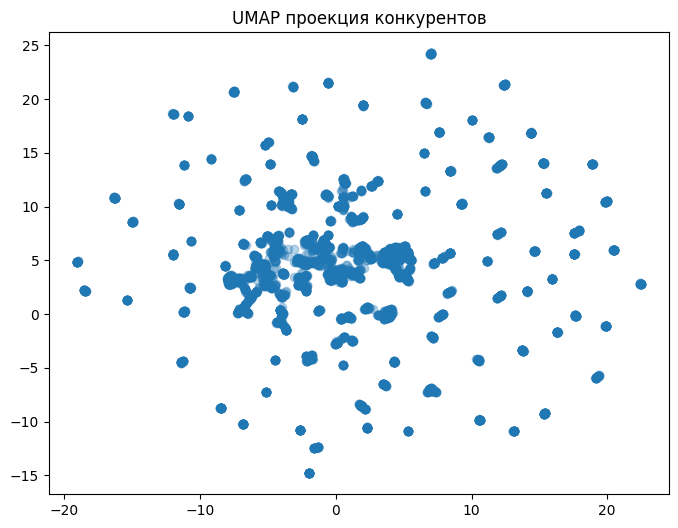

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_umap = reducer.fit_transform(full_info_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], alpha=0.3)
plt.title('UMAP проекция конкурентов')
plt.show()

**Поиск кластеров с помощью t-SNE**

In [ ]:
from sklearn.manifold import TSNE

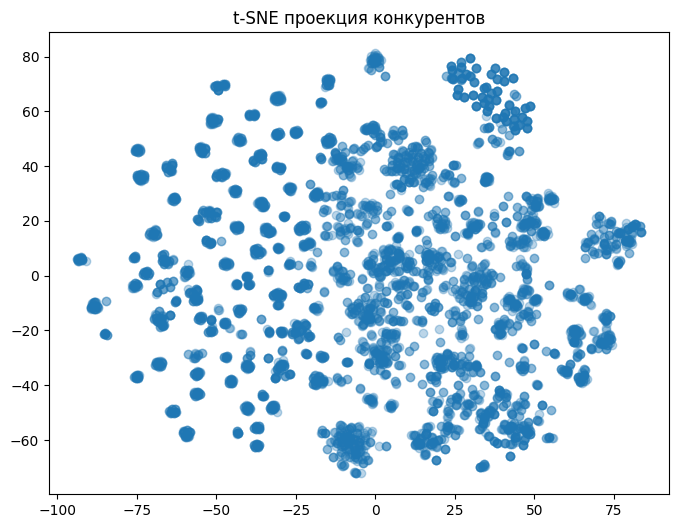

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding_tsne = tsne.fit_transform(full_info_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], alpha=0.3)
plt.title('t-SNE проекция конкурентов')
plt.show()

# Аппроксимация функции спроса с помощью ML и DL

Создание lag признаков

In [ ]:
df_prices.head()

In [ ]:
df_prices = df_prices.sort_values(['Sku (Sku)', 'Время (CollectedAt)']).copy()

df_prices['stock_prev'] = df_prices.groupby('Sku (Sku)')['Общий остаток (StockTotal)'].shift(1)

df_prices['sales'] = df_prices['stock_prev'] - df_prices['Общий остаток (StockTotal)']

df_prices['sales'] = df_prices['sales'].clip(lower=0)
df_prices.head()

In [ ]:
df_prices['lag_sales_1'] = df_prices.groupby('Sku (Sku)')['sales'].shift(1)
df_prices['lag_sales_2'] = df_prices.groupby('Sku (Sku)')['sales'].shift(2)

df_prices['lag_price_1'] = df_prices.groupby('Sku (Sku)')['Цена (BasePrice)'].shift(1)
df_prices['lag_price_sale_1'] = df_prices.groupby('Sku (Sku)')['Цена со скидкой (DiscountPrice)'].shift(1)
df_prices['lag_price_card_1'] = df_prices.groupby('Sku (Sku)')['Цена по карте (OzonCardPrice)'].shift(1)

In [ ]:
df_prices.dropna(inplace=True)
df_prices.head()

In [ ]:
df_prices['Время (CollectedAt)'] = pd.to_datetime(df_prices['Время (CollectedAt)'])

In [ ]:
df_prices['days_from_min'] = (df_prices['Время (CollectedAt)'] - df_prices['Время (CollectedAt)'].min()).dt.days

In [ ]:
df_prices.to_csv('processed_prices.csv')

In [ ]:
df_prices = pd.read_csv('processed_prices.csv')

**Сравнение моделей по RMSE**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [ ]:
X = df_prices.drop(['Время (CollectedAt)', 'sales'], axis=1)
y = df_prices['sales']

In [ ]:
%%time
# XGBoost

params = {
    'max_depth': [4, 6],
    'learning_rate': [0.03, 0.1, 0.2],
    'n_estimators': [300, 500],
}

grid_xgboost = GridSearchCV(XGBRegressor(random_state=42), params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
grid_xgboost.fit(X, y)

print(f'Лучший RMSE: {-grid_xgboost.best_score_}')
print(f'Лучшие гиперпараметры: {grid_xgboost.best_params_}')

Лучший RMSE: 13.611630321738076
Лучшие гиперпараметры: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 500}
CPU times: total: 21.4 s
Wall time: 2min 52s


In [ ]:
%%time
# CatBoost

params = {
    'depth': [6, 8],
    'learning_rate': [0.2, 0.3],
    'iterations': [700, 900],
}

grid_catboost = GridSearchCV(CatBoostRegressor(random_state=42, verbose=False), params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
grid_catboost.fit(X, y)

print(f'Лучший RMSE: {-grid_catboost.best_score_}')
print(f'Лучшие гиперпараметры: {grid_catboost.best_params_}')

Лучший RMSE: 9.762419503514296
Лучшие гиперпараметры: {'depth': 8, 'iterations': 900, 'learning_rate': 0.2}
CPU times: total: 3min 37s
Wall time: 20min 3s


In [ ]:
%%time
# LightGBM

params = {
    'max_depth' : [4, 6, 8],
    'learning_rate' : [0.03, 0.1],
    'n_estimators' : [300, 500],
}

grid_lgb = GridSearchCV(LGBMRegressor(random_state=42), params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
grid_lgb.fit(X, y)

print(f'Лучший RMSE: {-grid_lgb.best_score_}')
print(f'Лучшие гиперпараметры: {grid_lgb.best_params_}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 283538, number of used features: 13
[LightGBM] [Info] Start training from score 0.734974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

**Попробуем нейросетевые методы: TemporalFusionTransformer**

In [ ]:
df_nn = df_prices.drop('Время (CollectedAt)', axis=1).copy()

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length = 14
max_prediction_length = 4

training_cutoff = df_nn['days_from_min'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_nn[df_nn['days_from_min'] <= training_cutoff],
    time_idx='days_from_min',
    target='sales',
    group_ids=['Sku (Sku)'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)', 'Общий остаток (StockTotal)', 'Средний рейтинг (AvgRating)', 'stock_prev', 'lag_sales_1', 'lag_sales_2', 'lag_price_1', 'lag_price_sale_1', 'lag_price_card_1'],
    time_varying_unknown_reals=['sales'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
validation = TimeSeriesDataSet.from_dataset(training, df_nn, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

In [ ]:
from pytorch_forecasting import TemporalFusionTransformer
from lightning.pytorch import Trainer
import pytorch_lightning as pl
from pytorch_forecasting.metrics import RMSE

pl.seed_everything(42)
trainer = Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
    optimizer="ranger",
)
trainer = Trainer(
    max_epochs=8,
    gradient_clip_val=0.1,
    accelerator="auto",
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000027971CB9D00>
Traceback (most recent call last):
  File "D:\jupyter\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "D:\jupyter\Lib\site-packages\torch\utils\data\dataloader.py", line 1622, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "D:\jupyter\Lib\site-packages\torch\utils\data\dataloader.py", line 1558, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch 0:   4%|█▋                                    | 60/1335 [02:10<46:20,  0.46it/s, v_num=10, train_loss_step=20.40]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.4 K  | tr

Epoch 0: 100%|████████████████████████████████████| 1335/1335 [12:41<00:00,  1.75it/s, v_num=12, train_loss_step=3.300]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 85/85 [00:13<00:00,  6.37it/s]
Epoch 1: 100%|█| 1335/1335 [13:02<00:00,  1.71it/s, v_num=12, train_loss_step=1.720, val_loss=2.690, train_loss_epoch=1
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 85/85 [00:09<00:00,  9.03it/s]
Epoch 2: 100%|█| 1335/1335 [13:00<00:00,  1.71it/s, v_num=12, train_loss_step=2.280, val_loss=1.890, train_loss_epoch=7
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████████████


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
trainer.validate(tft, dataloaders=val_dataloader)

Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 85/85 [00:07<00:00, 11.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    0.4245656132698059     │
│         val_MAPE          │        26861728.0         │
│         val_RMSE          │    1.5108563899993896     │
│         val_SMAPE         │    1.9773398637771606     │
│         val_loss          │    1.5108563899993896     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.5108563899993896,
  'val_SMAPE': 1.9773398637771606,
  'val_MAE': 0.4245656132698059,
  'val_RMSE': 1.5108563899993896,
  'val_MAPE': 26861728.0}]

In [ ]:
trainer.save_checkpoint("tft_checkpoint.ckpt")

In [ ]:
tft_imported = TemporalFusionTransformer.load_from_checkpoint("tft_checkpoint.ckpt")

Epoch 0:   7%|██▎                              | 96/1335 [3:02:13<39:11:49,  0.01it/s, v_num=11, train_loss_step=34.90]


In [ ]:
trainer.validate(tft_imported, dataloaders=val_dataloader)

D:\jupyter\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 85/85 [00:07<00:00, 11.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    0.4245656132698059     │
│         val_MAPE          │        26861728.0         │
│         val_RMSE          │    1.5108563899993896     │
│         val_SMAPE         │    1.9773398637771606     │
│         val_loss          │    1.5108563899993896     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.5108563899993896,
  'val_SMAPE': 1.9773398637771606,
  'val_MAE': 0.4245656132698059,
  'val_RMSE': 1.5108563899993896,
  'val_MAPE': 26861728.0}]

# Поиск оптимального сочетания цен с помощью Байесовской оптимизации

In [ ]:
df_nn.groupby('Sku (Sku)')['sales'].nunique().sample()

Sku (Sku)
733215431    3
Name: sales, dtype: int64

In [ ]:
tft.predict(
    training.filter(lambda x: x['Sku (Sku)'] == 733215431), #.to_dataloader(train=False, batch_size=64),
    trainer_kwargs=dict(accelerator="cpu"),
).mean(1)

D:\jupyter\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor([0.4391, 0.4835, 0.4791, 0.5475, 0.5430, 0.5383, 0.5330, 0.5680, 0.5629,
        0.5221, 0.5176, 0.5073, 0.5028, 0.5538, 0.5491, 0.5019, 0.4973, 0.4876,
        0.4826])

In [ ]:
df_nn[df_nn['Sku (Sku)'] == 733215431]

In [ ]:
sku_id = 733215431
sku_df = df_nn[df_nn["Sku (Sku)"] == sku_id].groupby('days_from_min').mean().reset_index().copy()

In [ ]:
preds = tft.predict(sku_df.iloc[:18, :]).numpy()
for i in range(1, sku_df.shape[0]-18):
    preds = np.vstack([preds, tft.predict(sku_df.iloc[:i+18, :]).numpy()])

In [ ]:
print(f'Выручка при текущей ценовой политике за последние 10 дней: {(sku_df.iloc[18:, :][['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)']].mean(axis=1) * preds.mean(axis=1).clip(0)).sum()}')

Выручка при текущей ценовой политике за последние 10 дней: 12527.220984091693


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import scipy

def kernel(a, b, l=0.1):
    d = scipy.spatial.distance.cdist(a/l, b/l, metric='euclidean')
    return (1 + 5**0.5 * d + (5/3) * d**2) * np.exp(-5**0.5 * d)

In [ ]:
def posterior(X_s, X_train, Y_train, l=1, sigma_y=0.01):

    K = kernel(X_train, X_train, l) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l)
    K_ss = kernel(X_s, X_s, l) + 0.01 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)

    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

In [ ]:
def expected_improvement(X, X_sample, Y_sample, beta=3, **kwargs):
    mu, cov = posterior(X, X_sample, Y_sample, l=l_param, sigma_y=0.01)
    sigma = np.sqrt(np.diag(cov))

    return mu + beta * sigma

In [ ]:
def propose_location(acquisition, X_sample, Y_sample, bounds, n_restarts=10):

    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):

        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample).flatten().mean()

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = scipy.optimize.minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:

            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)

In [ ]:
def neuro_predict(X, i):
    y = []
    for j in range(X.shape[0]):
        cur_day = pd.DataFrame(sku_df.iloc[i+17, :].copy()).T
        cur_day[['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)']] = X[j, :]
        cur_day['days_from_min'] = cur_day['days_from_min'].astype('int64')
        y.append(tft.predict(pd.concat([sku_df.iloc[:i+17, :], cur_day])).numpy().mean(axis=1).clip(0) * X[j, :].mean())
    return np.array(y)

In [ ]:
np.random.seed(4)
preds = tft.predict(sku_df.iloc[:18, :]).numpy()

for i in range(1, sku_df.shape[0]-18):
    cur = sku_df.iloc[i+17, :]
    real_prices = np.array(cur[['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)']])
    X_init = np.vstack([real_prices, real_prices*np.array([0.8, 1, 1.2]), real_prices*np.array([1.2, 0.8, 1])])
    Y_init = neuro_predict(X_init, i)

    X_sample = X_init
    Y_sample = Y_init

    bounds = np.array([[0, 10000.0]])

    n_iter = 20

    l_param = 1.5

    for k in tqdm(range(n_iter)):

        X_next = propose_location(expected_improvement, X_sample, Y_sample, bounds).ravel()

        Y_next = neuro_predict(np.array([X_next]), i)

        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

    cur_day = pd.DataFrame(sku_df.iloc[i+17, :].copy()).T
    cur_day[['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)']] = X_sample[np.argmax(Y_sample)]
    cur_day['days_from_min'] = cur_day['days_from_min'].astype('int64')
    cur = pd.concat([sku_df.iloc[:i+17, :], cur_day])
    preds = np.vstack([preds, tft.predict(cur).numpy()])


%|                                                                                           | 0/20 [00:00<?, ?it/s]
%|████▏                                                                              | 1/20 [00:03<01:00,  3.17s/it]
%|████████▎                                                                          | 2/20 [00:06<00:55,  3.11s/it]
%|████████████▍                                                                      | 3/20 [00:10<00:58,  3.41s/it]
%|████████████████▌                                                                  | 4/20 [00:13<00:52,  3.25s/it]
%|████████████████████▊                                                              | 5/20 [00:15<00:47,  3.14s/it]
%|████████████████████████▉                                                          | 6/20 [00:19<00:47,  3.40s/it]
%|█████████████████████████████                                                      | 7/20 [00:22<00:42,  3.27s/it]
%|█████████████████████████████████▏                           

In [ ]:
print(f'Выручка при оптимизированной ценовой политике за последние 10 дней: {(cur.iloc[17:, :][['Цена (BasePrice)', 'Цена со скидкой (DiscountPrice)', 'Цена по карте (OzonCardPrice)']].mean(axis=1) * preds.mean(axis=1).clip(0)).sum()}')

Выручка при оптимизированной ценовой политике за последние 10 дней: 14508.888659428907


In [ ]:
cur.drop('Unnamed: 0', axis=1)